In [2]:
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data

In [3]:
""" SPX ticker symbol is ^GSPC on Yahoo Finance """
from_date = datetime.datetime(1960, 1, 1) 
to_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_url = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=' + from_date.strftime('%s') + '&period2=' + to_date.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/spx_HistoricalData.csv'
max_age_days = 7

df = load_data(csv_url, local_file, max_age_days)

Using local file


In [4]:
""" Data Transformation """
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1960-01-04,59.910000,59.910000,59.910000,59.910000,59.910000,3990000
1960-01-05,60.389999,60.389999,60.389999,60.389999,60.389999,3710000
1960-01-06,60.130001,60.130001,60.130001,60.130001,60.130001,3730000
1960-01-07,59.689999,59.689999,59.689999,59.689999,59.689999,3310000
1960-01-08,59.500000,59.500000,59.500000,59.500000,59.500000,3290000


In [5]:
""" Chart Variables"""
start_year = 1960

# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df['Adj Close'].last_valid_index()

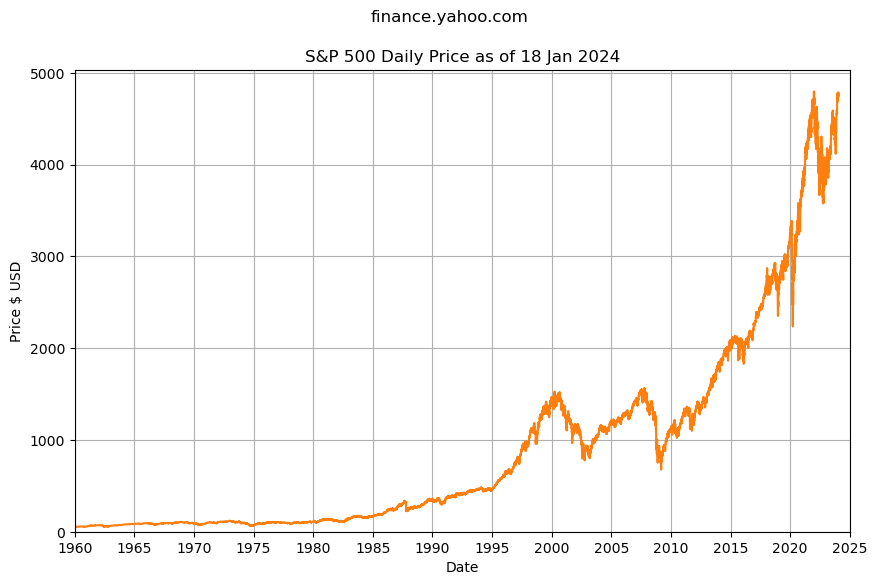

In [6]:
plt.figure(figsize=(10, 6))
colors = list(plt.rcParams['axes.prop_cycle'])
plt.plot(df.index, df['Adj Close'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Price $ USD')
plt.suptitle('finance.yahoo.com')
plt.title('S&P 500 Daily Price as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
plt.ylim(bottom=0) #, top=top_limit)     
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.grid(True)

plt.savefig(os.path.join('..', 'pages', 'images', 'spx-history.png'), bbox_inches='tight')
plt.show()

In [7]:
# Year over Year (YoY) change based on 252 trading days per year
annual_trading_days = 252
df['YoY'] = df['Adj Close'].pct_change(periods=annual_trading_days)*100
# add column 'YoY3YA' for three year rolling average
df['YoY3YA'] = df['YoY'].rolling(window=(annual_trading_days*3)).mean()
df.tail()

,Open,High,Low,Close,Adj Close,Volume,YoY,YoY3YA
Date,,,,,,,,
2024-01-11,4792.129883,4798.500000,4739.580078,4780.240234,4780.240234,3759890000,21.968240,11.992244
2024-01-12,4791.180176,4802.399902,4768.979980,4783.830078,4783.830078,3486340000,20.511334,11.997733
2024-01-16,4772.350098,4782.339844,4747.120117,4765.979980,4765.979980,4260550000,19.652942,12.003089
2024-01-17,4739.129883,4744.229980,4714.819824,4739.209961,4739.209961,3928600000,18.507207,12.006350
2024-01-18,4760.100098,4785.790039,4740.569824,4780.939941,4780.939941,4019000000,19.793934,12.012174


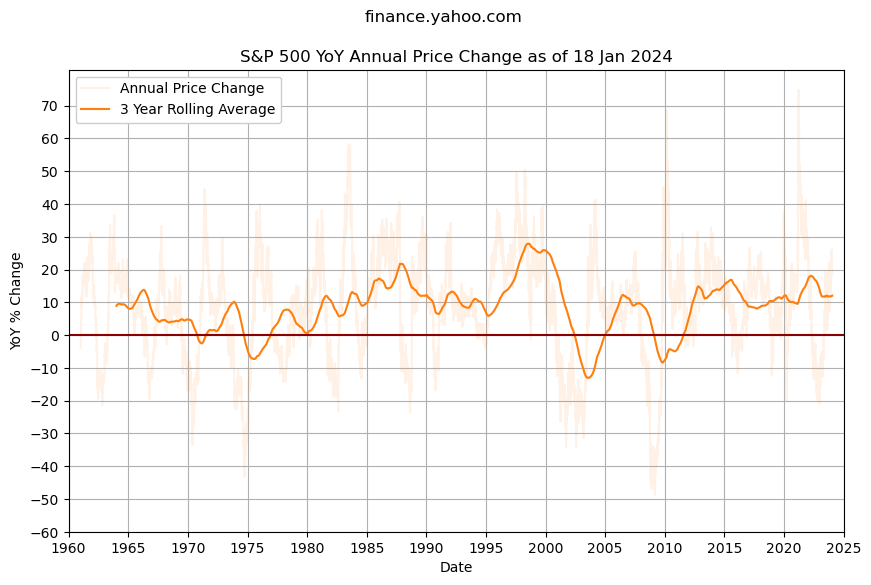

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['YoY'], label='Annual Price Change', color=colors[1]['color'], alpha=0.1)
plt.plot(df.index, df['YoY3YA'], label='3 Year Rolling Average', color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.suptitle('finance.yahoo.com')
plt.title('S&P 500 YoY Annual Price Change as of ' + last_index.strftime('%d %b %Y'))
left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 2000:
    tick_years = 1
else:
    tick_years = 5
top_limit = 80
bottom_limit = -60
#plt.ylim(bottom=bottom_limit, top=top_limit)
plt.yticks(range(bottom_limit, top_limit, 10))
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years

plt.axhline(y=0, color='darkred')  # Add horizontal line at y=0
plt.grid(True)

legend = plt.legend() #loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)

plt.savefig(os.path.join('..', 'pages', 'images', 'spx-yoy.png'), bbox_inches='tight')
plt.show()